# Customer Churn

Customers have been leaving "Beta Bank" every month. Not in large numbers, but noticeably. Bank marketers have calculated that retaining current customers is cheaper than attracting new ones.

You need to predict whether a customer will leave the bank in the near future or not. Historical data on customer behavior and contract terminations with the bank have been provided.

Build a model with the highest possible F1-score. To successfully complete the project, you need to achieve a metric of 0.59. Evaluate the F1-score on the test set yourself.

Additionally, measure AUC-ROC and compare its value with the F1-score.

Source of data: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    recall_score, 
    precision_score, 
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('/content/Churn_Modelling.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data.info()
# Create a function to rename columns:
def rename_columns(data):
  list_columns_new = []
  list_columns_old = list(data.columns)
  for column in data.columns:
    column = column[0].lower() + column[1:]
    for i in range(len(column)):
      if column[i].isupper():
        column = column[0: i] + '_' + column[i].lower() + column[i+1:]
    list_columns_new.append(column)
  for j in range(len(list_columns_old)):
    data = data.rename(columns={list_columns_old[j]: list_columns_new[j]})
  return data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The data types are correctly assigned, and there are no anomalies. The only thing left is to rename the columns to follow Python table formatting conventions. To achieve this, I created a function.

In [5]:
data = rename_columns(data)
# Проверим
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
data.describe(include='all')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [7]:
data.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

No missing values, that's great.

In [8]:
# Create a list of feature and target column names
columns_features = ['credit_score', 'geography', 'gender', 'age', 'tenure', 
                    'balance', 'num_of_products', 
                    'has_cr_card', 'is_active_member', 'estimated_salary']
column_target = ['exited']

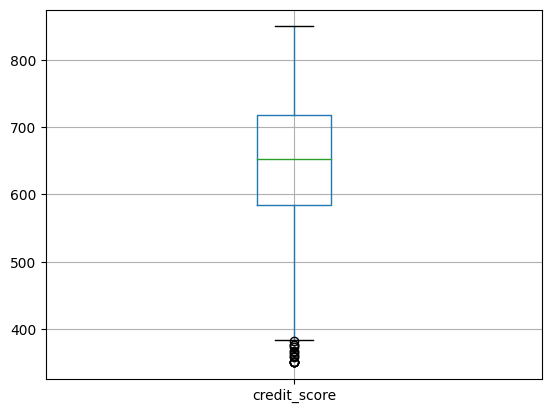

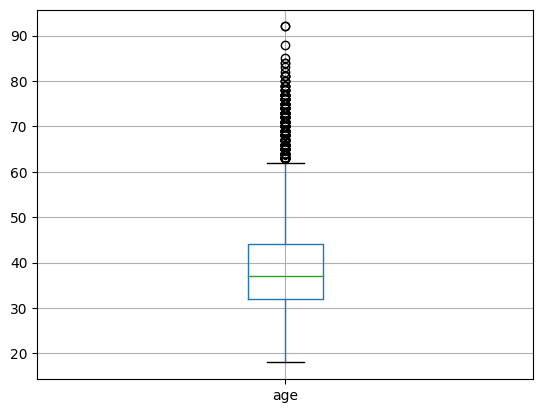

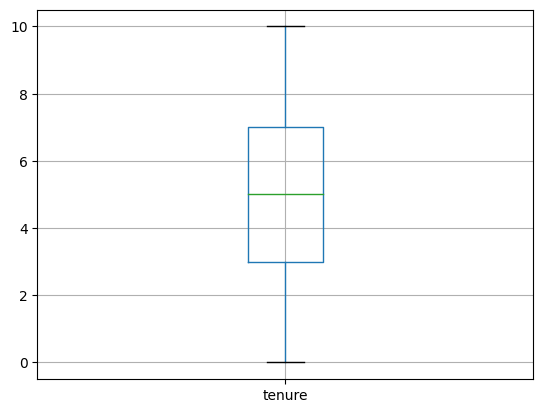

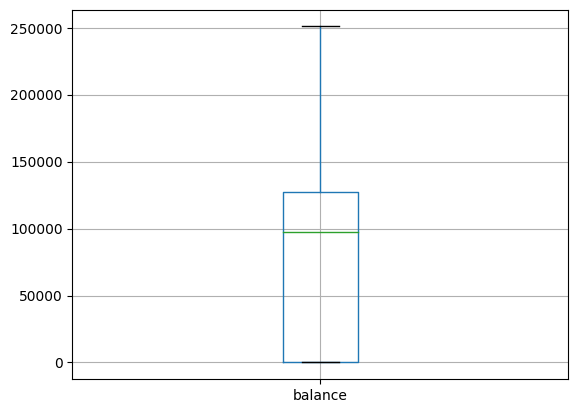

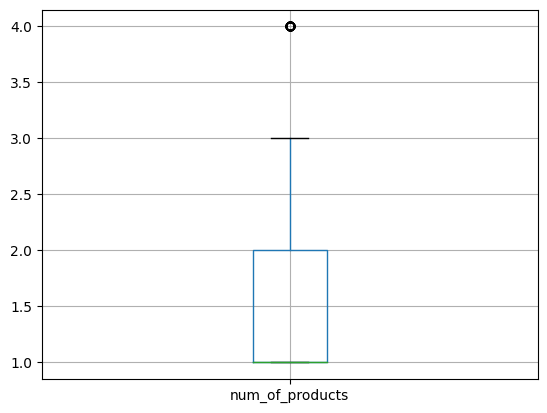

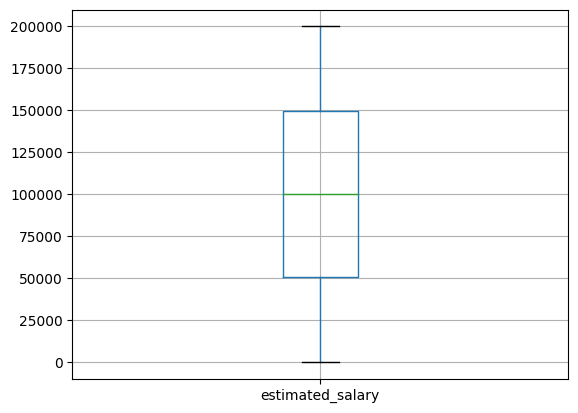

In [9]:
# Examine the data for outliers
for col in ['credit_score', 'age', 'tenure', 'balance', 
            'num_of_products', 'estimated_salary']:
  data.boxplot(column=col)
  plt.show()

I did not find significant outliers; the data behaves normally.

In [10]:
# Check other columns
for feat in ['geography', 'gender', 'has_cr_card', 'is_active_member']:
  print(data[feat].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']
[1 0]
[1 0]


No unusual findings or implicit duplicates were detected; we can proceed to the analysis.

**Conclusion:**

The data was opened and checked for integrity. The check for missing values revealed that there are no missing values. Additionally, no outliers that could significantly affect the model's quality were detected. The data is fully suitable for obtaining a relevant prediction.

## Exploration of the Task

In [11]:
# Create the feature and target datasets
features = data[columns_features]
target = data[column_target]

In [12]:
# To avoid multicollinearity, we will check the correlation:
features.corr()

<ipython-input-12-6760f04a5034>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corr()


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797
num_of_products,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204
has_cr_card,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933
is_active_member,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000


No strong correlation was found, so we will not encounter multicollinearity issues.

In [13]:
target.mean()

exited    0.2037
dtype: float64

There is a strong class imbalance with a ratio of 8:2 between the zero and one classes. Such a significant class imbalance may deteriorate the model's quality. We will keep this in mind, but for now, let's proceed with encoding and normalizing the features.

In [14]:
encoder = OrdinalEncoder()
features_ordinal =  pd.DataFrame(encoder.fit_transform(features), 
                                 columns=features.columns)
# Проверим
features_ordinal

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0
...,...,...,...,...,...,...,...,...,...,...
9995,380.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4827.0
9996,125.0,0.0,1.0,17.0,10.0,124.0,0.0,1.0,1.0,5087.0
9997,318.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,2062.0
9998,381.0,1.0,1.0,24.0,3.0,427.0,1.0,1.0,0.0,4639.0


We will use ordinal encoding for categorical features. Since models work only with numerical features, it is necessary to convert all data into numbers.

In [15]:
# Let's split the data into training and testing sets
features_train, features_valid_test, target_train, target_valid_test =\
train_test_split(features_ordinal, target, test_size=0.4, random_state=404540,
                 stratify=target)

features_valid, features_test, target_valid, target_test =\
train_test_split(features_valid_test, target_valid_test, test_size=0.5, 
                 random_state=404540, stratify=target_valid_test)

In [16]:
# Let's scale the data:
numeric = ['credit_score', 'age', 'tenure', 'balance', 
           'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] =  scaler.transform(features_train[numeric])
features_valid[numeric] =  scaler.transform(features_valid[numeric])
features_test[numeric] =  scaler.transform(features_test[numeric])

Normalization is necessary to equalize the importance of features for the model. This step is crucial when feature values differ significantly, as in our case, where we observe a substantial difference between the features `age` and `balance` (with means and standard deviations differing by more than 1000 times!).

In [17]:
for i in [features_train, features_valid, features_test, target_train, 
          target_valid, target_test]:
  print(i.shape)

(6000, 10)
(2000, 10)
(2000, 10)
(6000, 1)
(2000, 1)
(2000, 1)


In [18]:
best_model_tree = None
best_prediction = None
best_f1 = 0
for depth in range(1, 21):
  model = DecisionTreeClassifier(random_state=404540, max_depth=depth)
  model.fit(features_train, target_train)
  prediction = model.predict(features_valid)
  if best_f1 < f1_score(target_valid, prediction):
    best_model_tree = model
    best_prediction = prediction
print('Лучшая модель')
print(best_model_tree)
print('F1 без борьбы с дисбалансом - решающее дерево')
print(f1_score(target_valid, best_prediction))
print('ROC_AUC без борьбы с дисбалансом - решающее дерево')
probabilities = best_model_tree.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
DecisionTreeClassifier(max_depth=20, random_state=404540)
F1 без борьбы с дисбалансом - решающее дерево
0.48418491484184917
ROC_AUC без борьбы с дисбалансом - решающее дерево
0.6766751343022529


The decision tree model evaluation with class imbalance showed mediocre results.

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
best_model_forest = None
best_prediction = None
best_f1 = 0
for depth in range (1, 21):
  for est in range(10, 151, 10):
    model = RandomForestClassifier(random_state=404540, max_depth=depth,
                                   n_estimators=est)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if best_f1 < f1:
      best_f1 = f1
      best_model_forest = model
      best_prediction = prediction
print('Лучшая модель')
print(best_model_forest)
print('F1 без борьбы с дисбалансом - случайный лес')
print(f1_score(target_valid, best_prediction))
print('ROC_AUC без борьбы с дисбалансом - случайный лес')
probabilities = best_model_forest.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
RandomForestClassifier(max_depth=12, n_estimators=90, random_state=404540)
F1 без борьбы с дисбалансом - случайный лес
0.5828220858895705
ROC_AUC без борьбы с дисбалансом - случайный лес
0.8437173691410981


The random forest model also didn't impress with its results, but it was closer to the baseline.

**Conclusion:**

Testing models on data without addressing class imbalance yielded poor results, confirming the need to take measures to handle class imbalance.

## Handling Class Imbalance

In [21]:
# Let's check how the class_weight hyperparameter performs for the Random Forest model
best_model_tree = None
best_prediction = None
best_f1 = 0
for depth in range(1, 20):
  model = DecisionTreeClassifier(random_state=404540, max_depth=depth, 
                                 class_weight='balanced')
  model.fit(features_train, target_train)
  prediction = model.predict(features_valid)
  f1 = f1_score(target_valid, prediction)
  if best_f1 < f1:
    best_f1 = f1
    best_model_tree_1 = model
    best_prediction = prediction
print('Лучшая модель')
print(best_model_tree_1)
print('F1 борьба с дисбалансом - решающее дерево')
print(f1_score(target_valid, best_prediction))
print('ROC_AUC борьба с дисбалансом - решающее дерево')
probabilities = best_model_tree_1.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       random_state=404540)
F1 борьба с дисбалансом - решающее дерево
0.5488029465930019
ROC_AUC борьба с дисбалансом - решающее дерево
0.8258281393874614


In [22]:
# Let's check how the hyperparameter class_weight performs for the Random Forest model
best_model_forest_1 = None
best_prediction = None
best_f1 = 0
for depth in range (1, 21):
  for est in range(10, 151, 10):
    model = RandomForestClassifier(random_state=404540, max_depth=depth, 
                                   n_estimators=est, class_weight='balanced')
    model.fit(features_train, target_train)
    f1 = f1_score(target_valid, prediction)
    prediction = model.predict(features_valid)
    if best_f1 < f1:
      best_f1 = f1 
      best_model_forest_1 = model
      best_prediction = prediction
print('Лучшая модель')
print(best_model_forest_1)
print('F1 борьба с дисбалансом - случайный лес')
print(best_f1)
print('ROC_AUC борьба с дисбалансом - случайный лес')
probabilities = best_model_forest_1.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=50,
                       random_state=404540)
F1 борьба с дисбалансом - случайный лес
0.6190476190476191
ROC_AUC борьба с дисбалансом - случайный лес
0.8482079922757889


The results are worse compared to when the `class_weight=None` hyperparameter was used.

In [23]:
# Let's try to increase the samples
oversample = SMOTE(random_state=404540)

features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)

In [24]:
print(target_train.sum())
print(target_train.count())
print(target_train_up.sum())
print(target_train_up.count())

exited    1222
dtype: int64
exited    6000
dtype: int64
exited    4778
dtype: int64
exited    9556
dtype: int64


The function is working correctly

The random forest model with increased sampling and the class_weight='balanced' hyperparameter showed good results. We'll focus on this model and try to improve it by hyperparameter tuning

In [25]:
best_model_tree = None
best_prediction = None
best_f1 = 0
for depth in range(1, 20):
  model = DecisionTreeClassifier(random_state=404540, max_depth=depth)
  model.fit(features_train_up, target_train_up)
  prediction = model.predict(features_valid)
  f1 = f1_score(target_valid, prediction)
  if best_f1 < f1:
    best_f1 = f1
    best_model_tree_2 = model
    best_prediction = prediction
print('Лучшая модель')
print(best_model_tree_2)
print('F1 борьба с дисбалансом - решающее дерево')
print(f1_score(target_valid, best_prediction))
print('ROC_AUC борьба с дисбалансом - решающее дерево')
probabilities = best_model_tree_2.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
DecisionTreeClassifier(max_depth=5, random_state=404540)
F1 борьба с дисбалансом - решающее дерево
0.5646817248459959
ROC_AUC борьба с дисбалансом - решающее дерево
0.8174869785039276


In [26]:
best_model_forest_2 = None
best_prediction = None
best_f1 = 0
for depth in range (1, 21):
  for est in range(10, 151, 10):
    model = RandomForestClassifier(random_state=404540, max_depth=depth, 
                                   n_estimators=est)
    model.fit(features_train_up, target_train_up)
    f1 = f1_score(target_valid, prediction)
    prediction = model.predict(features_valid)
    if best_f1 < f1:
      best_f1 = f1 
      best_model_forest_2 = model
      best_prediction = prediction
print('Лучшая модель')
print(best_model_forest_2)
print('F1 борьба с дисбалансом - случайный лес')
print(best_f1)
print('ROC_AUC борьба с дисбалансом - случайный лес')
probabilities = best_model_forest_2.predict_proba(features_valid)[:, 1]
print(roc_auc_score(target_valid, probabilities))

Лучшая модель
RandomForestClassifier(max_depth=13, n_estimators=40, random_state=404540)
F1 борьба с дисбалансом - случайный лес
0.6067961165048543
ROC_AUC борьба с дисбалансом - случайный лес
0.8468537875317538


In [27]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(features_train_up, target_train_up)
dummy_pred = dummy.predict(features_valid)

In [28]:
# Проверим модель:
prediction = best_model_forest_2.predict(features_valid)
print('Лучшая модель')
print(confusion_matrix(target_valid, prediction))
print('f1_score:', f1_score(target_valid, prediction))
print('Precision:', precision_score(target_valid, prediction))
print('Recall:', recall_score(target_valid, prediction))
print('Accuracy:', accuracy_score(target_valid, prediction))
print('Dummy Model')
print(confusion_matrix(target_valid, dummy_pred))
print('f1_score:', f1_score(target_valid, dummy_pred))
print('Precision:', precision_score(target_valid, dummy_pred))
print('Recall:', recall_score(target_valid, dummy_pred))
print('Accuracy:', accuracy_score(target_valid, dummy_pred))

Лучшая модель
[[1433  160]
 [ 161  246]]
f1_score: 0.6051660516605166
Precision: 0.6059113300492611
Recall: 0.6044226044226044
Accuracy: 0.8395
Dummy Model
[[   0 1593]
 [   0  407]]
f1_score: 0.3381803074366431
Precision: 0.2035
Recall: 1.0
Accuracy: 0.2035


The best model has been identified. The model has been validated for adequacy. The final step is to evaluate the model on the test dataset.

## Model Testing

In [31]:
prediction =  best_model_forest_2.predict(features_test)
print('F1 score - тестовая выборка, лучашя модель')
print(f1_score(target_test, prediction))
print('ROC AUC - тестовая выборка, лучшая модель')
probabilities = model.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, probabilities))

F1 score - тестовая выборка, лучашя модель
0.5911458333333334
ROC AUC - тестовая выборка, лучшая модель
0.8472971475022169
0.843


**Summary:**

*Brief Description of the Project Process:*

I opened the dataset, explored and transformed the data to ensure the best results from the model. I encountered class imbalance in the dataset, which significantly impacted model accuracy. To address this issue, I increased the sample size of the minority class and tuned the model’s hyperparameters to achieve the best performance.

After these steps, I obtained a model capable of predicting customer churn effectively.

*Technical Details of the Model:*

The best hyperparameters for the model were: `max_depth = 13`, `n_estimators = 40`, and it was trained on an expanded sample. The model achieved an accuracy of 84%, an AUC-ROC of 0.85, and an F1 score of 0.591, meeting the project goal. To ensure the model's adequacy, I used a baseline model predicting only the majority class. The confusion matrix confirmed that our model predicts both classes, though with less efficiency for the minority class, which is expected due to the inherent class imbalance. The accuracy, F1 score, and precision of the baseline model were lower compared to the best model, except for recall, which was higher, indicating that our model does not predict only the majority class.

*Business Application of the Model:*

Predicting customer churn can be highly valuable for the bank as it allows for proactive measures to retain clients and enhance loyalty. Potential business applications include:

1. **Customer Retention:** If the model predicts that a particular customer is likely to leave, the bank can take actions to retain them, such as offering better credit terms, discounts, or bonuses.
2. **Improving Service Quality:** Analyzing data from customers who left can help the bank identify the reasons for their departure and address any issues.
3. **Increasing Profitability:** Predicting churn can help the bank reduce costs associated with acquiring new customers and focus on retaining existing ones.
4. **Forecasting Future Customer Needs:** Understanding the behavior of departing customers can assist the bank in predicting their future needs and offering new products and services accordingly.